# 1. Setup
## 1.1 Install dependencies

In [74]:
# !pip list 

In [75]:
#!pip install opencv-python

## 1.2 Import dependencies 

In [76]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np 
from matplotlib import pyplot as plt

In [77]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

## 1.3 Set GPU Growth  

In [78]:
# Avoid OOM errors by setting GPU Memory Consumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create folder structures 

In [79]:
# Setup path
path_list = { 'POS_PATH' : os.path.join('data', 'positive'), 
              'NEG_PATH' : os.path.join('data', 'negative'), 
              'ANC_PATH' : os.path.join('data', 'anchor')}

In [80]:
# # Creating path
# for path in path_list:
#     if not os.path.exists(path_list[path]):
#         os.makedirs(path_list[path])

# Collect Positives and Anchors  

## 2.1 Untar Labelled Faces in Wild Dataset 

In [81]:
# http://vis-www.cs.umass.edu/lfw/

In [82]:
# # Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [83]:
# # Move LFW Images to the following repo data/negative 
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw',directory, file)
#         NEW_PATH = os.path.join(path_list['NEG_PATH'], file)
#         os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect postive and Anchor classes

In [84]:
# Import uuid to generate unique image names
import uuid

In [85]:
# Establish a connection with the webcam 
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Crop down the frame
    frame = frame[120:120+250, 120:120+250, :]
    
    # Collect anchor image
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imagename = os.path.join(path_list['ANC_PATH'], '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imagename, frame)
    
    # Collect positive image
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imagename = os.path.join(path_list['POS_PATH'], '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imagename, frame)
    
    # Show image back to screen 
    cv2.imshow('Image Collectio', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()                            

In [86]:
# plt.imshow(frame)

# 3. Load and Preprocess Images
## 3.1 Get Image Directories

In [87]:
anchor = tf.data.Dataset.list_files(path_list['ANC_PATH']+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(path_list['POS_PATH']+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(path_list['NEG_PATH']+'\*.jpg').take(300)

In [88]:
# dir test 
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\dfc99ac0-4bfc-11ec-b729-145afc2444fe.jpg'

## 3.2 Preprocessing - Scale and Resize 

In [89]:
def preprocess(file_path):
    #Read in image file from path
    img = tf.io.read_file(file_path)
    #Load in image
    img = tf.io.decode_jpeg(img)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img/255.0
    
    # Return image
    return img

In [90]:
img = preprocess('data\\anchor\\eb272d40-4bfc-11ec-bb99-145afc2444fe.jpg')

In [91]:
img.numpy().max()

0.89362746

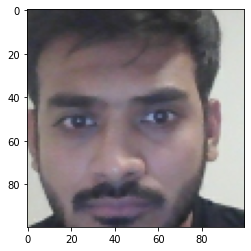

In [92]:
plt.imshow(img)

## 3.3 Create labelled Dataset

In [93]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [94]:
samples = data.as_numpy_iterator()
example = samples.next()

In [95]:
example

(b'data\\anchor\\ec65aaf4-4bfc-11ec-bbf4-145afc2444fe.jpg',
 b'data\\positive\\04c48772-4bfd-11ec-a1cd-145afc2444fe.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [96]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [97]:
res = preprocess_twin(*example)

In [98]:
print(res[2])

1.0


In [99]:
# Build dataloader pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [100]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [101]:
# Testing partition
test_data = data.skip
test_data = data.take(round(len(data)*.7))
test_data = train_data.batch(16)
test_data = train_data.prefetch(8)

# Model Engineering 

## 4.1 Building Embedding Layer 

In [102]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embedded block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedded')

In [103]:
embedding = make_embedding()

In [104]:
embedding.summary()

Model: "embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       262

## 4.2 Building Distance Layer

In [105]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

## 4.3 Make Siamese Model 

In [106]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape= (100,100,3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=[classifier], name='SiameseNetwork')

In [107]:
siamese_model = make_siamese_model()

In [108]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedded (Functional)          (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer 

In [109]:
# Binary crossentropy loss
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [110]:
# Adam optimizer
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints 

In [111]:
checkpoint_dir = os.path.join('training_checkpoints')

In [112]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [113]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

In [114]:
if not os.path.exists(checkpoint_prefix):
    os.makedirs(checkpoint_prefix)

In [115]:
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function 

In [116]:
@tf.function
def train_step(batch):
    #Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label 
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [117]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run training step
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model 

In [118]:
EPOCHS = 50

In [119]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 7s 175ms/step

 Epoch 2/50
27/27 [==============================] - 4s 162ms/step

 Epoch 3/50
27/27 [==============================] - 4s 154ms/step

 Epoch 4/50
27/27 [==============================] - 4s 141ms/step

 Epoch 5/50
27/27 [==============================] - 4s 141ms/step

 Epoch 6/50
27/27 [==============================] - 4s 142ms/step

 Epoch 7/50
27/27 [==============================] - 4s 142ms/step

 Epoch 8/50
27/27 [==============================] - 4s 140ms/step

 Epoch 9/50
27/27 [==============================] - 4s 141ms/step

 Epoch 10/50
27/27 [==============================] - 4s 141ms/step

 Epoch 11/50
27/27 [==============================] - 4s 140ms/step

 Epoch 12/50
27/27 [==============================] - 4s 140ms/step

 Epoch 13/50
27/27 [==============================] - 4s 141ms/step

 Epoch 14/50
27/27 [==============================] - 4s 141ms/step

 Epoch 15/50
27/27 [======================

# 6. Evaluate Model

## 6.1 Import Metrics 

In [120]:
# Import metrics calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Preductions 

In [121]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [122]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[4.1712287e-06],
       [1.0000000e+00],
       [6.0524326e-06],
       [9.4941512e-05],
       [1.6397101e-09],
       [9.9997604e-01],
       [2.0558992e-10],
       [9.9999976e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.1450325e-08],
       [9.9996710e-01],
       [9.9933511e-01],
       [1.0000000e+00],
       [9.3245797e-07],
       [1.7169926e-07]], dtype=float32)

In [123]:
# Post processing
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0]

In [124]:
y_true

array([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics 

In [125]:
# Creating a Recall metrics object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [126]:
# Creating a Precision metrics object
p = Precision()

# Calculating the recall value
p.update_state(y_true, y_hat)

# Return Recall Result
p.result().numpy()

1.0

## 6.4 Visualize Results 

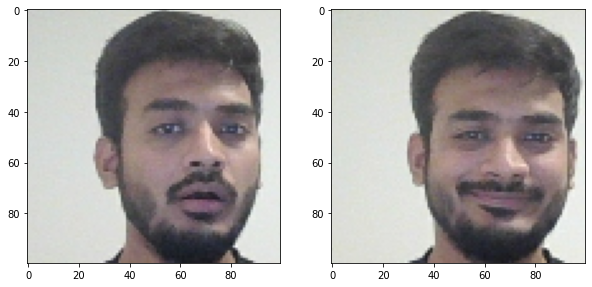

In [127]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot 
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot 
plt.subplot(1,2,2)
plt.imshow(test_val[5])

# Renders cleanly
plt.show()

# 7. Save model

In [128]:
# Save model
siamese_model.save('siamese_model.h5')

In [129]:
# Load model
model = tf.keras.models.load_model('siamese_model.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [130]:
model.predict([test_input, test_val])

array([[4.1712287e-06],
       [1.0000000e+00],
       [6.0524326e-06],
       [9.4941512e-05],
       [1.6397101e-09],
       [9.9997604e-01],
       [2.0558992e-10],
       [9.9999976e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.1450325e-08],
       [9.9996710e-01],
       [9.9933511e-01],
       [1.0000000e+00],
       [9.3245797e-07],
       [1.7169926e-07]], dtype=float32)

In [131]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedded (Functional)          (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function 

In [132]:
application_data_path = os.path.join('application_data')
if not os.path.exists(application_data_path):
    os.makedirs(application_data_path)

In [133]:
input_iamge_path = os.path.join(application_data_path, 'input_image')
if not os.path.exists(input_iamge_path):
    os.makedirs(input_iamge_path)

In [134]:
verification_image_path = os.path.join(application_data_path, 'verification_images')
if not os.path.exists(verification_image_path):
    os.makedirs(verification_image_path)

In [135]:
# copy random images from positive folder to varification_images folder
import random
import shutil

source = path_list['POS_PATH']
dest = verification_image_path

files = os.listdir(source)
total_files_to_move = 50

# for file_name in random.sample(files, total_files_to_move):
#     shutil.copy(os.path.join(source, file_name), dest)

In [142]:
# Verification function 
def verify(model, detection_threshold, verification_threshold):
    input_image = preprocess(os.path.join(input_iamge_path, 'input_image.jpg'))
    
    # Build result array
    results = []
    # Prediction with each image in the verification_image folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        validation_image = preprocess(os.path.join(verification_image_path, image))
        result = model.predict(list(np.expand_dims([input_image, validation_image], axis=1)))
        results.append(result)  
    # print(results)
    # Detection Threshold: Metrics above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
#     print("detection:", detection)
    
    # Varification Thershold: ratio of positive predictions / total positives samples
    verification = detection / len(os.listdir(verification_image_path))
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification 

In [143]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verifiaction', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # same the input frame to input image
        cv2.imwrite(os.path.join(input_iamge_path, 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

False
True
True
False


In [146]:
print(np.array(results))

[[[0.37462994]]

 [[0.02491309]]

 [[0.84640276]]

 [[0.29844993]]

 [[0.6305167 ]]

 [[0.8374704 ]]

 [[0.92793435]]

 [[1.        ]]

 [[0.3413763 ]]

 [[0.9403763 ]]

 [[0.19741333]]

 [[1.        ]]

 [[0.9988752 ]]

 [[1.        ]]

 [[1.        ]]

 [[1.        ]]

 [[1.        ]]

 [[0.9995479 ]]

 [[0.77669245]]

 [[0.12297655]]

 [[1.        ]]

 [[1.        ]]

 [[0.79647905]]

 [[0.831221  ]]

 [[0.2931918 ]]

 [[0.26909783]]

 [[1.        ]]

 [[0.9999989 ]]

 [[0.9999999 ]]

 [[1.        ]]

 [[1.        ]]

 [[0.9896808 ]]

 [[0.992007  ]]

 [[0.9999871 ]]

 [[0.99999964]]

 [[0.88027656]]

 [[0.9995789 ]]

 [[0.88114846]]

 [[0.3423988 ]]

 [[0.99998796]]

 [[0.99996805]]

 [[0.9972875 ]]

 [[0.9999995 ]]

 [[0.999231  ]]

 [[0.9980774 ]]

 [[0.3527983 ]]

 [[0.2672486 ]]

 [[0.5706531 ]]

 [[0.8998857 ]]

 [[0.90014714]]]


In [147]:
np.sum(np.array(results)>.9)

29

In [148]:
29/50

0.58